Author: Charlie Moffett, NYU CUSP, 2017

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import geopandas as gpd
import os
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


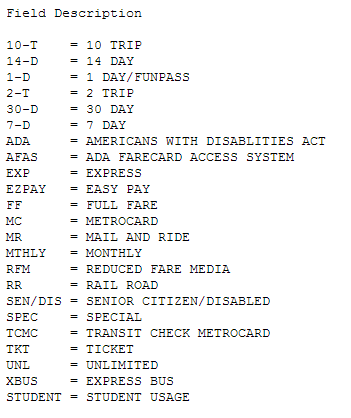

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




### Task 1: Event detection: Identify the most prominent event.

In [3]:
# establish path to my PUIdata folder
dPath = os.getenv('PUIDATA')

# read in # of swipes per week, stored as a python data cube
swipes = np.load(dPath + '/MTA_Fare.npy')

swipes[1]

array([[16210, 20179, 21769, ...,    -1,    -1,    -1],
       [  503,   647,   665, ...,    -1,    -1,    -1],
       [   41,    43,    44, ...,    -1,    -1,    -1],
       ..., 
       [    0,     0,     0, ...,    -1,    -1,    -1],
       [    0,     0,     0, ...,    -1,    -1,    -1],
       [   -1,    -1,    -1, ...,    -1,    -1,    -1]], dtype=int32)

In [4]:
# dates array
dates_arr = pd.date_range(start='05/21/2010', periods=194, freq='W-FRI')

# rider typology array
user_arr = np.array(['10 Trip', '14 Day', '1 Day', '2 Trip', '30 Day', '7 Day', 'ADA', 'ADA FAS', 'Express', 'EZ-Pay',
            'Full fare', 'Metrocard', 'Mail & Ride', 'Montly', 'Reduced fare media', 'Railroad', 'Senior citizen/disabled',
            'Special', 'Transit check metrocard', 'Ticket', 'Unlimited', 'Express bus', 'Student usage'])

from Hints: 

"*If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc*"

In [5]:
# convert swipe values of -1 to NaN values
swipes = swipes.astype(float)
swipes[swipes==-1] = np.nan

# aggregate NaNs to axis=1 (by rider typology)
swipes_agg = np.nansum(swipes, axis=1)

## aggregate on 0 axis (by station)
station_agg = np.sum(swipes_agg, axis=0)

print(swipes.shape)
print(swipes_agg.shape)
print(station_agg.shape)

(600, 23, 194)
(600, 194)
(194,)


In [6]:
# key moments for station aggregation
sMean = np.mean(station_agg)
sStd = np.std(station_agg)
print("{:.5f}, {:.5f}".format(sMean, sStd))

29781349.87113, 2983960.42170


In [7]:
# calculate three sigma threshold
sThresh = [sMean + 3 * sStd, sMean - 3 * sStd]
sThresh

[38733231.136236683, 20829468.606031362]

Text(0,0.5,'Number of swipes (tens of millions)')

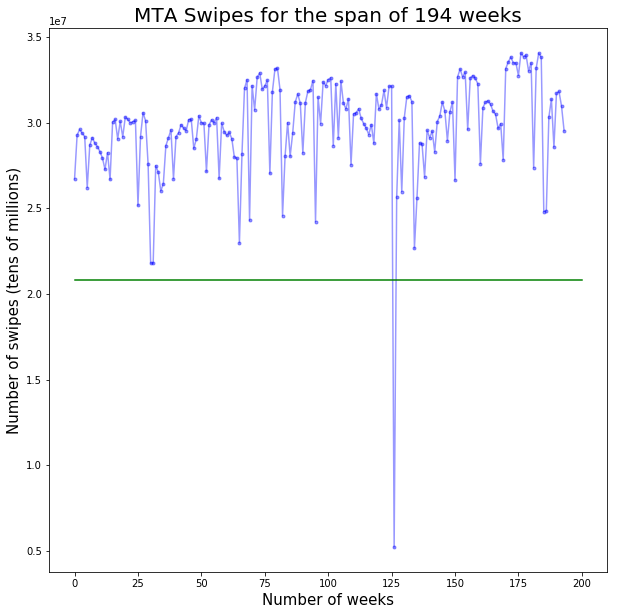

In [8]:
# Plot station aggregation with respect to threshold
ax = pl.figure(figsize=(10,10))
pl.plot(station_agg,'b.-', alpha=0.4)
pl.plot((0,200), (sThresh[1], sThresh[1]), 'g-')
pl.title('MTA Swipes for the span of 194 weeks', fontsize=20)
pl.xlabel('Number of weeks', fontsize=15)
pl.ylabel('Number of swipes (tens of millions)', fontsize=15)

__Figure 1: MTA subway card swipes per week, aggregated by subway station. Immediately obvious is the outlier at week 126, which corresponds to widespread station closures as a result of superstorm Sandy in October 2012.__

### Task 2: Identify/quantify the **ridership types**  that have steadily increased/decreased in popularity.

In [10]:
# aggregate swipe data again using rider typology
#riders = np.nansum(data, axis=0)
riders = np.nansum(swipes, axis=0)

# convert above array to pandas dataframe
riders = pd.DataFrame(riders).T

riders.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
3,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
4,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


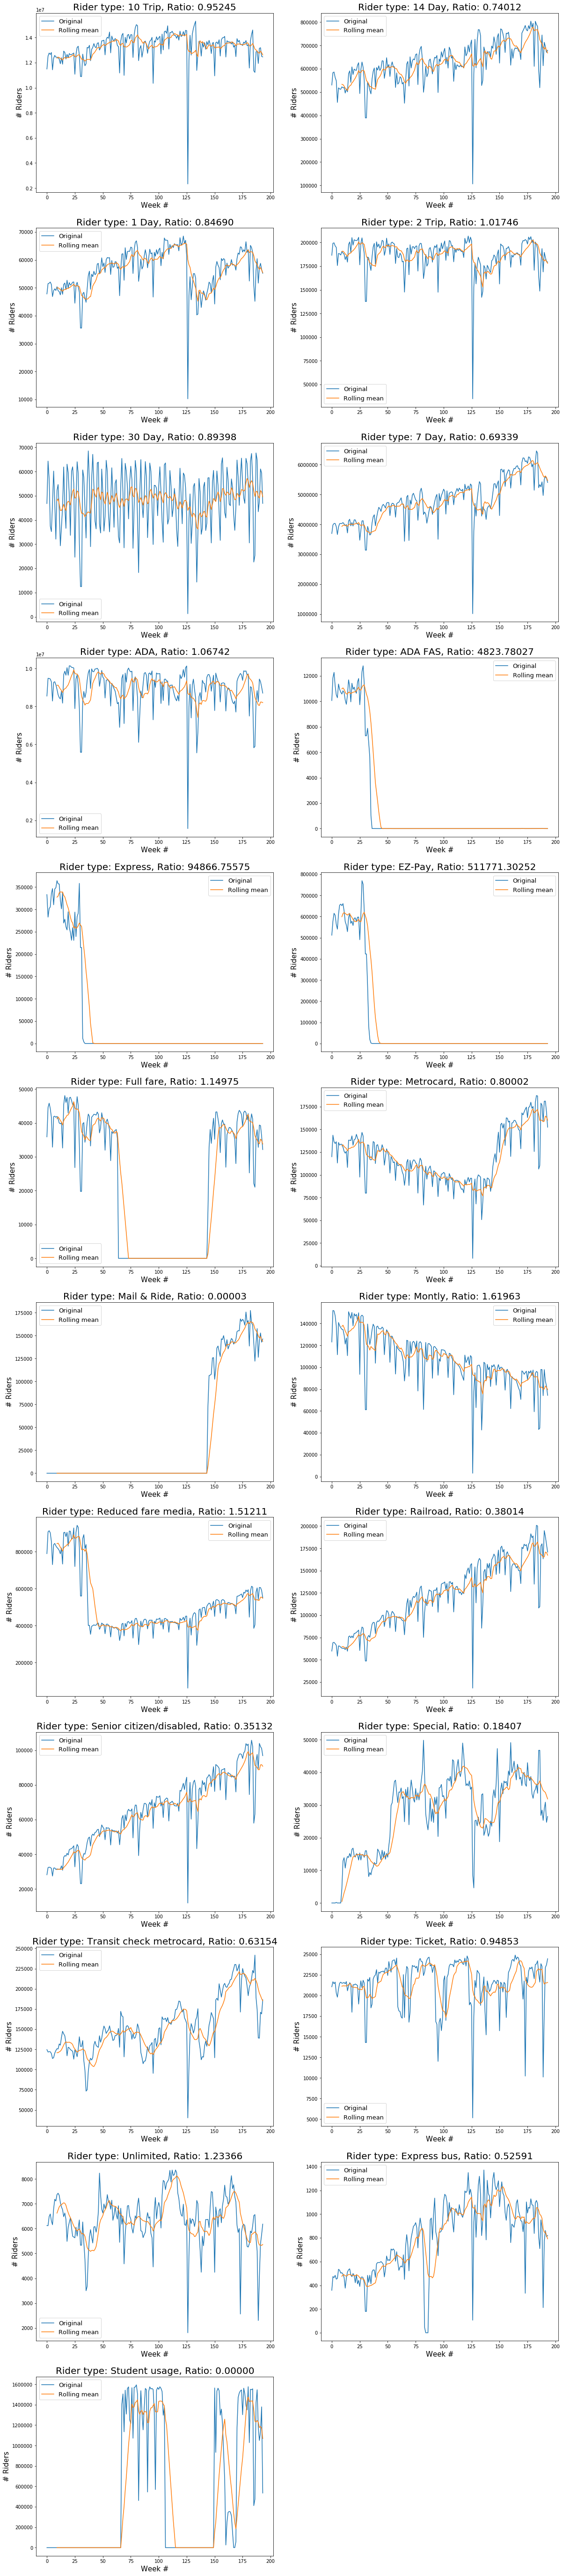

In [11]:
# plot by rider type & ratio of first/last 10 weeks of subway use
fig = pl.figure(figsize=(20, 100))
ratio = []

for i in range(len(riders.columns)):
    ax = fig.add_subplot(12,2,i+1)
    riders_rmean = pd.rolling_mean(riders[i], 10)
    ax.plot(np.arange(len(riders[i])), riders[i], label="Original")
    ax.plot(np.arange(len(riders[i])), riders_rmean, label="Rolling mean")
    ratio.append(pd.rolling_mean(riders[i], 10).dropna().head(10).sum() / pd.rolling_mean(riders[i], 10).dropna().tail(10).sum())
    ax.set_title("Rider type: {}, Ratio: {:.5f}".format(user_arr[i], ratio[i]), fontsize=20)
    pl.ylabel("# Riders", fontsize=15)
    pl.xlabel("Week #", fontsize=15)
    pl.legend(fontsize=13)

__Figure 2: 23 time series plots measuring changes in subway 'popularity' - number of MTA subway riders by week for 194 weeks. Each plot represents a different rider type. Through this series of visualizations, we're able to observe stationarity across rider typology and the associated trends (pos and neg) for each.__ 

__Below I detail the prominent stationary rider types.__

In [12]:
print('The following rider types appear stationary:')
for i in range(len(riders.columns)):
    fTest = sm.tsa.adfuller(riders.iloc[:,i])
    if fTest[0] > fTest[4]['5%']:
        pass
    else:
        print('{}'.format(user_arr[i]))

The following rider types appear stationary:
10 Trip
2 Trip
30 Day
ADA
Express
Transit check metrocard
Ticket
Unlimited


In [13]:
pd.DataFrame(list(zip(user_arr, ratio)), columns=['Rider Type', 'Ratio'])

,Rider Type,Ratio
0,10 Trip,0.952452
1,14 Day,0.740123
2,1 Day,0.846901
3,2 Trip,1.017463
4,30 Day,0.893979
5,7 Day,0.693391
6,ADA,1.067421
7,ADA FAS,4823.780269
8,Express,94866.755747
9,EZ-Pay,511771.302521


### Task 3: Identify the 4 **stations** that show the most prominent periodic trend on an annual period (52 weeks).

from Hints:

"*There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collapse" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations.*"

Text(0,0.5,'Power')

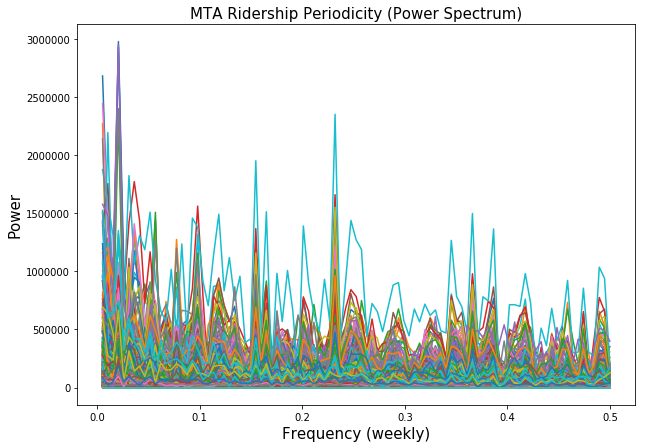

In [14]:
# identifying stations
# time series for power spectrum 
fig = pl.figure(figsize=(10,7))
ax = fig.add_subplot(111)
station_agg = np.nansum(swipes, axis=1)

for i in range(len(station_agg)):
    f = np.abs(np.fft.rfft(station_agg[i]))
    ax.plot(np.fft.rfftfreq(len(station_agg[1]), 1.0)[1:], (f[1:]), '-')
ax.set_title('MTA Ridership Periodicity (Power Spectrum)', fontsize=15)
ax.set_xlabel('Frequency (weekly)', fontsize=15)
ax.set_ylabel('Power', fontsize=15)

__Figure 3: This is a "power spectrum": a plot of the absolute value of the Fourier transform.__

__Periodicity power spectrum plot showing each of our MTA subway stations over the 194 week period. By plotting power (magnitude) against the frequency measure of periodicity we observe prominent periodic trends amongst our set of MTA stops.__

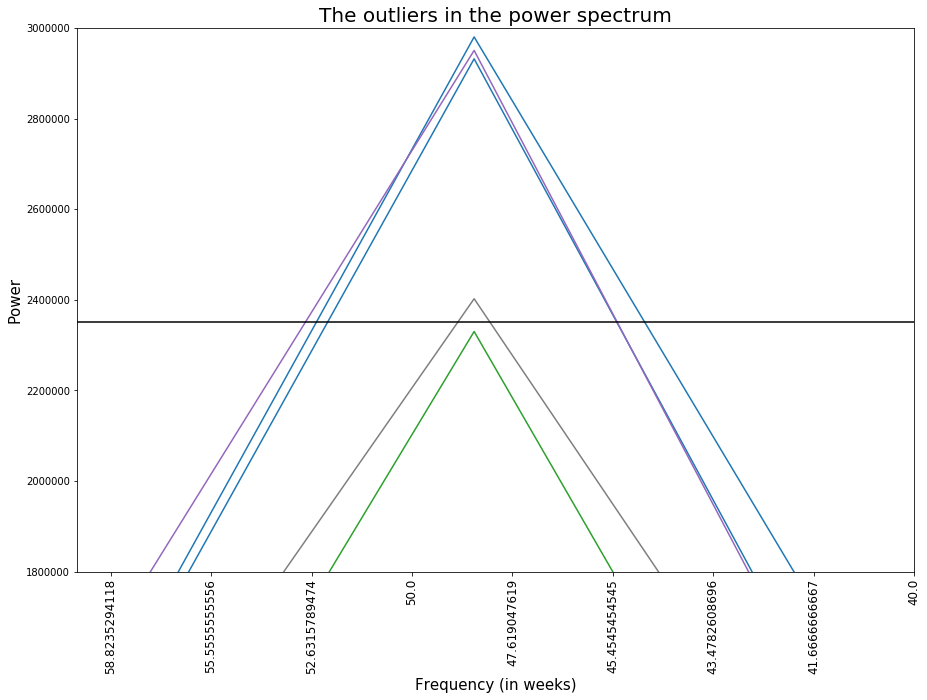

In [15]:
# bring back in threshold to measure outliers from our power spectrum plot
fig = pl.figure(figsize=(15,10))
ax = fig.add_subplot(111)

whitebox = []

for i in range(len(station_agg)):
    f = np.abs(np.fft.rfft(station_agg[i]))
    ax.plot(np.fft.rfftfreq(len(station_agg[1]), 1.0)[1:], (f[1:]), '-')
    if (f[4] > 2360000):
        whitebox.append(i);

ax.set_ylim([1800000, 3000000])
ax.plot((1./60, 1./40), (2350000, 2350000), 'k-')
ax.set_xlim(1./60, 1./40)
ax.set_xticklabels([ "%.2f"%(1/4./f) for f in ax.get_xticks()], fontsize=12, rotation=60)
pl.xlabel("Frequency (in weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)
pl.title("The outliers in the power spectrum", fontsize=20)
#ax.set_xlim(1/80., 1/30.)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=90);

__FIgure 4: A version of what we saw in the previous plot. Here however we can look at those power peaks in relation to our threshold from earlier. The four stations (IDs below) that demonstrate outstanding periodicity on a 52-week cycle are shown here surpassing the threshold.__

In [16]:
print("the 4 stations that show the most prominent periodic trend on an annual period:\n{}".format(whitebox))

the 4 stations that show the most prominent periodic trend on an annual period:
[0, 150, 194, 327]


NameError: name 'index' is not defined

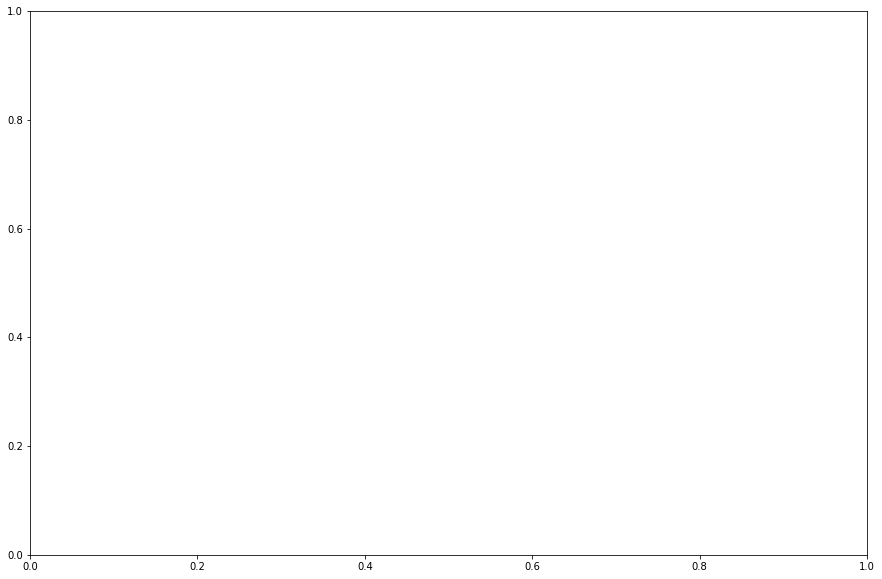

In [17]:
# plot this periodicity as time series for our four stations
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
for i in index:
    ax.plot(dates_arr, station_agg[i], label=i)
ax.legend()
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('# of Rides', fontsize=15)
pl.title('Prominently Periodic Stations', fontsize=20);

__Figure 5: MTA swipes over the 194 week period - we have a better grasp of the extreme periodicity of these four stations by examining the time series trends here. What's striking is the impact of Fridays, and the predictablitity of these ride spikes for the stations listed above.__

### EXTRA CREDIT: Cluster the time series, i.e. identify groups of time series that look similar among each other. 

In [18]:
# flatten the first 2 dimensions of the cube to cluster all light curves for all stations and all types
my_tots = swipes.transpose(2,0,1).reshape(swipes.shape[2], swipes.shape[1]*swipes.shape[0]).T

# remove empty light curves
my_tots = my_tots[my_tots.std(1)>0]

# standardize the lightcurves before clustering
values = ((my_tots.T - my_tots.mean(1))/my_tots.std(1)).T

In [19]:
# choose the number of clusters for and run Kmeans
kimet = KMeans(n_clusters=5, init='k-means++').fit(values)
fitV = kimet.fit_predict(values)
fitV

array([0, 2, 2, ..., 0, 2, 3], dtype=int32)

Text(0.5,1,'MTA Time Series - Clustering!')

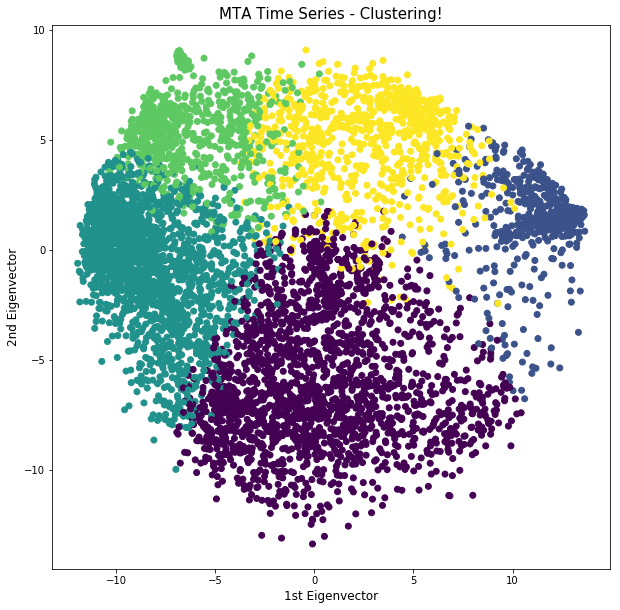

In [20]:
# take the principle components 
n=4
pca = PCA(n)
project_X = pca.fit_transform(values)
ev = pca.explained_variance_

# and plot Eigenvectors against one another
plt.figure(figsize=(10, 10))
plt.scatter(project_X[:, 0], project_X[:, 1], c=fitV)
plt.xlabel('1st Eigenvector', fontsize=12)
plt.ylabel('2nd Eigenvector', fontsize=12)
pl.title('MTA Time Series - Clustering!', fontsize=15)

__Figure 6: In this plot I identify time series that look similar to one another. Clustering allows us to identify common trends.__

Grade: 10/10